# **Kim-CNN Word2Vec-based Classifier**

In [1]:
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import seaborn as sb

# **Exploring The Dataset**

In [ ]:
# 1. Load the Text File
file_path = 'data.csv'
with open(file_path, 'r', encoding='utf-8') as file:
    news = pd.read_csv(file_path)

In [ ]:
news.head()

In [ ]:
news.info()

In [ ]:
sb.countplot(x='label',data=news)
plt.title("Distrbution of labels")
plt.xlabel("Label")
plt.ylabel("Frequancy")
plt.show();

# **Split the data into Traine - Test set**

In [5]:
from sklearn.model_selection import train_test_split

# Separate the features and the target variable
X = news['text']
y = news['label']               

# Split the data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **1. Preprocess Your Data**

**Tokenization & Padding:**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 1. a. Tokenize the train text
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)

# 1. b. Tokenize the train text
sequences_test = tokenizer.texts_to_sequences(x_test)

# 2. Compute the 95th percentile of these lengths
train_sequence_lengths = [len(seq) for seq in sequences_train]
max_length = int(np.percentile(train_sequence_lengths, 95))
print("Chosen max sequence length (95th percentile):", max_length)

# 3. Use the max length as the max_sequence_length for padding/truncation
max_sequence_length = max_length
x_train = pad_sequences(sequences_train, maxlen=max_sequence_length)

max_sequence_length = max_length
x_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

word_index = tokenizer.word_index


Chosen max sequence length (95th percentile): 868


**load word2vec modle**

In [7]:
path = r"../models/GoogleNews-vectors-negative300.bin.gz"
word2vec_model = KeyedVectors.load_word2vec_format(path, binary=True)

# **2. Prepare the Embedding Layer**

**Embedding Matrix from Pre-trained Word2Vec:**


In [ ]:

embedding_dim = 300  # Google News word2vec using 300D
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]


**Create an Embedding layer in Keras**

In [9]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_sequence_length,
    trainable=False  # Use False to keep the embeddings fixed
)


C:\Users\007T\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# **3. Build the Kim-CNN Architecture**

**Architecture Components:**

**1. Input Layer:** Accepts the padded sequences.

**2. Embedding Layer:** Converts word indices to word vectors.

**3. Convolutional Layers:** Apply several 1D convolution filters with different kernel sizes (e.g., 3, 4, 5) to capture various n-gram features.

**4. Global Max-Pooling:** For each filter, apply max pooling over the time dimension (i.e., across the sentence length) to capture the most significant feature.

**5. Concatenation:** Merge the outputs of the different filters.

**6. Dropout:** Apply dropout for regularization.

**7. Dense Layer:** Final classification layer with a softmax (or sigmoid) activation for prediction.

In [10]:
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Dense

# Define hyperparameters
filter_sizes = [3, 4, 5]   # Different filter sizes for n-grams
num_filters = 128          # Number of filters per size
dropout_rate = 0.5
num_classes = 2            # Adjust based on your classification task

# Input layer
sequence_input = Input(shape=(max_sequence_length,), dtype='int32')

# Embedding layer (using the pre-trained word2vec embeddings)
embedded_sequences = embedding_layer(sequence_input)

# Create a convolution + pooling layer for each filter size
conv_layers = []
for filter_size in filter_sizes:
    conv = Conv1D(
        filters=num_filters,
        kernel_size=filter_size,
        activation='relu'
    )(embedded_sequences)
    
    pool = GlobalMaxPooling1D()(conv)
    conv_layers.append(pool)

# Concatenate the pooled features from each filter
if len(conv_layers) > 1:
    merged = Concatenate()(conv_layers)
else:
    merged = conv_layers[0]

# Apply dropout for regularization
drop = Dropout(dropout_rate)(merged)

# Final dense layer for classification
preds = Dense(num_classes, activation='softmax')(drop)

# Define the model
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 868)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 868, 300)  │ 35,320,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 866, 128)  │    115,328 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 865, 128)  │    153,728 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 864, 128)  │    192,128 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │        770 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,782,454 (136.50 MB)

 Trainable params: 461,954 (1.76 MB)

 Non-trainable params: 35,320,500 (134.74 MB)

In [11]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(31953, 868) (31953,)
(7989, 868) (7989,)


In [12]:
import pickle
with open('tokenizer-on-text.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

**Training and Evaluating the Model**

Convert your labels to categorical format and train the model.

In [13]:
from tensorflow.keras.utils import to_categorical

# Convert binary labels (0 or 1) to one-hot encoded vectors (shape becomes (num_samples, 2))
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ModelCheckpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(
    filepath='kim-cnn-model-on-text.h5',      # Filepath where the model will be saved
    monitor='val_loss',            # Metric to monitor
    save_best_only=True,           # Only save the model if val_loss improves
    verbose=1                     # Print messages when the model is saved
)

# Train the model with the callbacks
model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=128,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8829 - loss: 0.2447
Epoch 1: val_loss improved from inf to 0.02585, saving model to kim-cnn-model-on-text.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 839s 3s/step - accuracy: 0.8832 - loss: 0.2442 - val_accuracy: 0.9959 - val_loss: 0.0258
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9949 - loss: 0.0264
Epoch 2: val_loss improved from 0.02585 to 0.01679, saving model to kim-cnn-model-on-text.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 780s 3s/step - accuracy: 0.9949 - loss: 0.0264 - val_accuracy: 0.9974 - val_loss: 0.0168
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9974 - loss: 0.0140
Epoch 3: val_loss improved from 0.01679 to 0.01109, saving model to kim-cnn-model-on-text.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 699s 3s/step - accuracy: 0.9974 - loss: 0.0140 - val_accuracy: 0.9980 - val_loss: 0.0111
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9988 - loss: 0.0092
Epoch 4: val_loss improved from 0.01109 to 0.00760, saving model to kim-cnn-model-on-text.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 719s 3s/step - accuracy: 0.9988 - loss: 0.0092 - val_accuracy: 0.9982 - val_loss: 0.0076
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9991 - loss: 0.0053
Epoch 5: val_loss improved from 0.00760 to 0.00636, saving model to kim-cnn-model-on-text.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 707s 3s/step - accuracy: 0.9991 - loss: 0.0053 - val_accuracy: 0.9987 - val_loss: 0.0064
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9989 - loss: 0.0041
Epoch 6: val_loss improved from 0.00636 to 0.00528, saving model to kim-cnn-model-on-text.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 717s 3s/step - accuracy: 0.9989 - loss: 0.0041 - val_accuracy: 0.9987 - val_loss: 0.0053
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9997 - loss: 0.0025
Epoch 7: val_loss did not improve from 0.00528
250/250 ━━━━━━━━━━━━━━━━━━━━ 712s 3s/step - accuracy: 0.9997 - loss: 0.0025 - val_accuracy: 0.9987 - val_loss: 0.0055
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9993 - loss: 0.0021
Epoch 8: val_loss did not improve from 0.00528
250/250 ━━━━━━━━━━━━━━━━━━━━ 702s 3s/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9987 - val_loss: 0.0053
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9997 - loss: 0.0017
Epoch 9: val_loss improved from 0.00528 to 0.00497, saving model to kim-cnn-model-on-text.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 716s 3s/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9989 - val_loss: 0.0050
Epoch 10/10
179/250 ━━━━━━━━━━━━━━━━━━━━ 3:31 3s/step - accuracy: 0.9993 - loss: 0.0022

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9651 - loss: 0.1042
Test Loss: 0.10491104423999786
Test Accuracy: 0.9642007946968079


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Generate predicted probabilities
y_pred_prob = model.predict(x_test)
# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
# Convert one-hot encoded y_test back to class labels
y_true = np.argmax(y_test, axis=1)

# Print classification report and confusion matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3996
           1       0.96      0.97      0.96      3993

    accuracy                           0.96      7989
   macro avg       0.96      0.96      0.96      7989
weighted avg       0.96      0.96      0.96      7989

[[3848  148]
 [ 138 3855]]


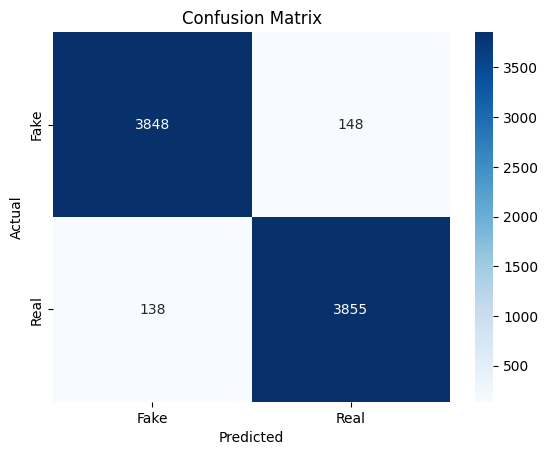

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_test is one-hot encoded, so convert to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
